In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

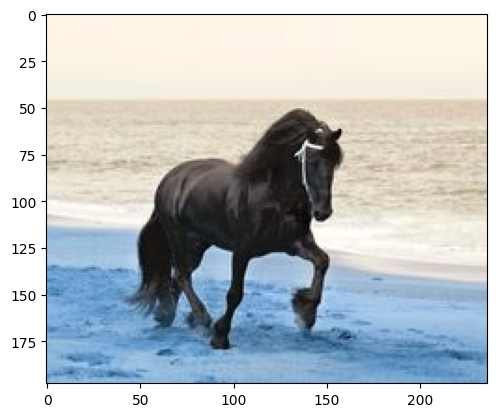

In [2]:
data_dir = "/kaggle/input/images-dataset/data/"

import cv2
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread(os.path.join(data_dir, "horses", "horse-1.jpg"))
plt.imshow(img)

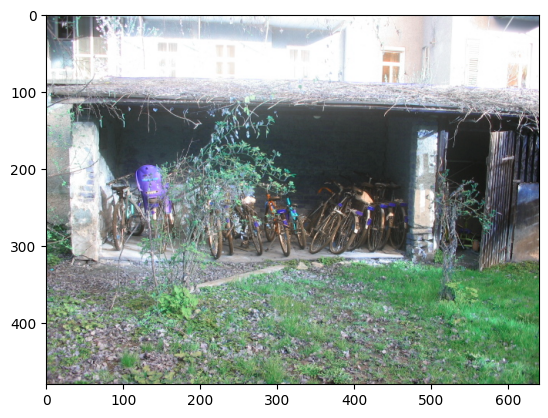

In [3]:
plt.imshow(cv2.imread("/kaggle/input/images-dataset/data/bike/bike_001.bmp"))

In [4]:
img.shape

(198, 236, 3)

(128, 128)


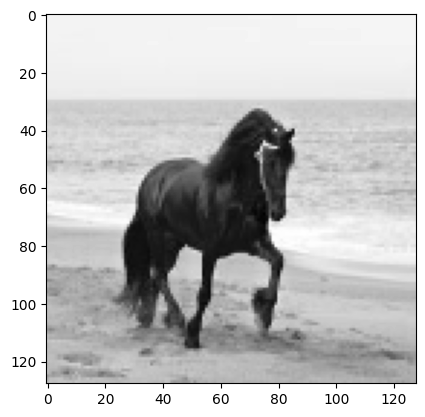

In [5]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray_img, (128,128))
print(resized.shape)
plt.imshow(resized, cmap="gray")
sample_data = np.expand_dims(resized, axis=0)
# input_data = np.expand_dims(input_data, axis=0)

sample_data = torch.from_numpy(sample_data).unsqueeze(0).float()

In [6]:
categories = os.listdir("/kaggle/input/images-dataset/data/")
# print(len(categories))
images = []
for cat in categories:
    temp_images = os.listdir(os.path.join(data_dir, cat))
    images.extend([f"{cat}/{img}" for img in temp_images])
images[:10]

['horses/horse-26.jpg',
 'horses/horse-193.jpg',
 'horses/horse-41.jpg',
 'horses/horse-176.jpg',
 'horses/horse-46.jpg',
 'horses/horse-3.jpg',
 'horses/horse-183.jpg',
 'horses/horse-166.jpg',
 'horses/horse-111.jpg',
 'horses/horse-61.jpg']

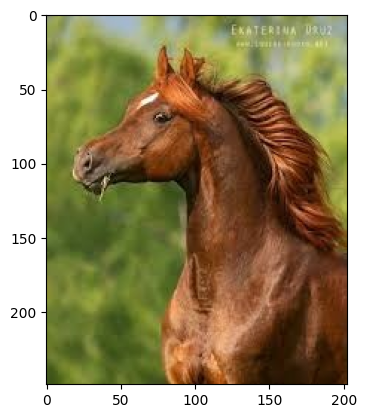

In [7]:
from PIL import Image
plt.imshow(Image.open(f"{data_dir}/{images[0]}"))

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
class MyDataset(Dataset):
    def __init__(self):
        self.data_dir = "/kaggle/input/images-dataset/data/"
        categories = os.listdir(self.data_dir)
        self.images = []
        for cat in categories:
            temp_images = os.listdir(os.path.join(data_dir, cat))
            temp_images = [f"{cat}/{img}" for img in temp_images]
            self.images.extend(temp_images)
        print("no of examples: ",len(self.images))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.data_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128,128))
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return transforms.ToTensor()(gray_image), transforms.ToTensor()(image)
    
class MyDataset(Dataset):
    def __init__(self):
        self.data_dir = "/kaggle/input/images-dataset/data/"
        categories = os.listdir(self.data_dir)
        self.images = []
        for cat in categories:
            temp_images = os.listdir(os.path.join(self.data_dir, cat))
            temp_images = [f"{cat}/{img}" for img in temp_images]
            self.images.extend(temp_images)
            break
        print("Number of examples: ", len(self.images))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.images[idx])
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image at {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (128, 128))
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        except Exception as e:
            print(f"Error loading image: {e}")
            image = np.random.rand(128, 128, 3) * 255
            gray_image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)

        return transforms.ToTensor()(gray_image), transforms.ToTensor()(image)


In [9]:
# Create an instance of your dataset
dataset = MyDataset()

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Test the data loader
for inputs, labels in data_loader:
    print(inputs.shape)
    print(labels.shape)

    break

Number of examples:  202
torch.Size([64, 1, 128, 128])
torch.Size([64, 3, 128, 128])


In [10]:
import torch
import torch.nn as nn
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.downconv1 = DoubleConv(1, 64)
        self.downconv2 = DoubleConv(64, 128)
        self.downconv3 = DoubleConv(128, 256)
        self.downconv4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2, bias=False)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2, bias=False)
        self.upconv3 = nn.ConvTranspose2d(128, 64, 2, 2, bias=False)
        self.upconv4 = nn.ConvTranspose2d(64, 3, 1, 1, bias=False)

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.pool(x1)
        x3 = self.downconv2(x2)
        x4 = self.pool(x3)
        x5 = self.downconv3(x4)
        x6 = self.pool(x5)
        x7 = self.downconv4(x6)
        x = self.upconv1(x7)
        x = self.upconv2(x + x5)
        x = self.upconv3(x + x3)
        x = self.upconv4(x + x1)
        return x
model = UNet()


In [11]:
model

UNet(
  (downconv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (downconv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (downconv3): DoubleConv(
 

Using device: cuda
Using 2 GPUs


Epoch 1/50: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 1 Loss: 1.3977795988321304
Checkpoint saved: /kaggle/working/model_epoch_1.pth


Epoch 2/50: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Epoch 2 Loss: 0.500435583293438
Checkpoint saved: /kaggle/working/model_epoch_2.pth


Epoch 3/50: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Epoch 3 Loss: 0.3187420293688774
Checkpoint saved: /kaggle/working/model_epoch_3.pth


Epoch 4/50: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


Epoch 4 Loss: 0.24312527105212212
Checkpoint saved: /kaggle/working/model_epoch_4.pth


Epoch 5/50: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Epoch 5 Loss: 0.1973901093006134
Checkpoint saved: /kaggle/working/model_epoch_5.pth


Epoch 6/50: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


Epoch 6 Loss: 0.1748511604964733
Checkpoint saved: /kaggle/working/model_epoch_6.pth


Epoch 7/50: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


Epoch 7 Loss: 0.16548584029078484
Checkpoint saved: /kaggle/working/model_epoch_7.pth


Epoch 8/50: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Epoch 8 Loss: 0.14247946068644524
Checkpoint saved: /kaggle/working/model_epoch_8.pth


Epoch 9/50: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Epoch 9 Loss: 0.13849391043186188
Checkpoint saved: /kaggle/working/model_epoch_9.pth


Epoch 10/50: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Epoch 10 Loss: 0.13698086328804493
Checkpoint saved: /kaggle/working/model_epoch_10.pth


Epoch 11/50: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


Epoch 11 Loss: 0.12770022451877594
Checkpoint saved: /kaggle/working/model_epoch_11.pth


Epoch 12/50: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Epoch 12 Loss: 0.11731126345694065
Checkpoint saved: /kaggle/working/model_epoch_12.pth


Epoch 13/50: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Epoch 13 Loss: 0.12434515915811062
Checkpoint saved: /kaggle/working/model_epoch_13.pth


Epoch 14/50: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Epoch 14 Loss: 0.12052132561802864
Checkpoint saved: /kaggle/working/model_epoch_14.pth


Epoch 15/50: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Epoch 15 Loss: 0.12015037797391415
Checkpoint saved: /kaggle/working/model_epoch_15.pth


Epoch 16/50: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Epoch 16 Loss: 0.11805112101137638
Checkpoint saved: /kaggle/working/model_epoch_16.pth


Epoch 17/50: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Epoch 17 Loss: 0.11052956245839596
Checkpoint saved: /kaggle/working/model_epoch_17.pth


Epoch 18/50: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Epoch 18 Loss: 0.11001124419271946
Checkpoint saved: /kaggle/working/model_epoch_18.pth


Epoch 19/50: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Epoch 19 Loss: 0.1182319987565279
Checkpoint saved: /kaggle/working/model_epoch_19.pth


Epoch 20/50: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Epoch 20 Loss: 0.11234665475785732
Checkpoint saved: /kaggle/working/model_epoch_20.pth


Epoch 21/50: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Epoch 21 Loss: 0.11766934208571911
Checkpoint saved: /kaggle/working/model_epoch_21.pth


Epoch 22/50: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Epoch 22 Loss: 0.10572798363864422
Checkpoint saved: /kaggle/working/model_epoch_22.pth


Epoch 23/50: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch 23 Loss: 0.10518195293843746
Checkpoint saved: /kaggle/working/model_epoch_23.pth


Epoch 24/50: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Epoch 24 Loss: 0.11140635795891285
Checkpoint saved: /kaggle/working/model_epoch_24.pth


Epoch 25/50: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Epoch 25 Loss: 0.11409744806587696
Checkpoint saved: /kaggle/working/model_epoch_25.pth


Epoch 26/50: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Epoch 26 Loss: 0.11584176309406757
Checkpoint saved: /kaggle/working/model_epoch_26.pth


Epoch 27/50: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Epoch 27 Loss: 0.11582295037806034
Checkpoint saved: /kaggle/working/model_epoch_27.pth


Epoch 28/50: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Epoch 28 Loss: 0.12107038870453835
Checkpoint saved: /kaggle/working/model_epoch_28.pth
Early stopping triggered


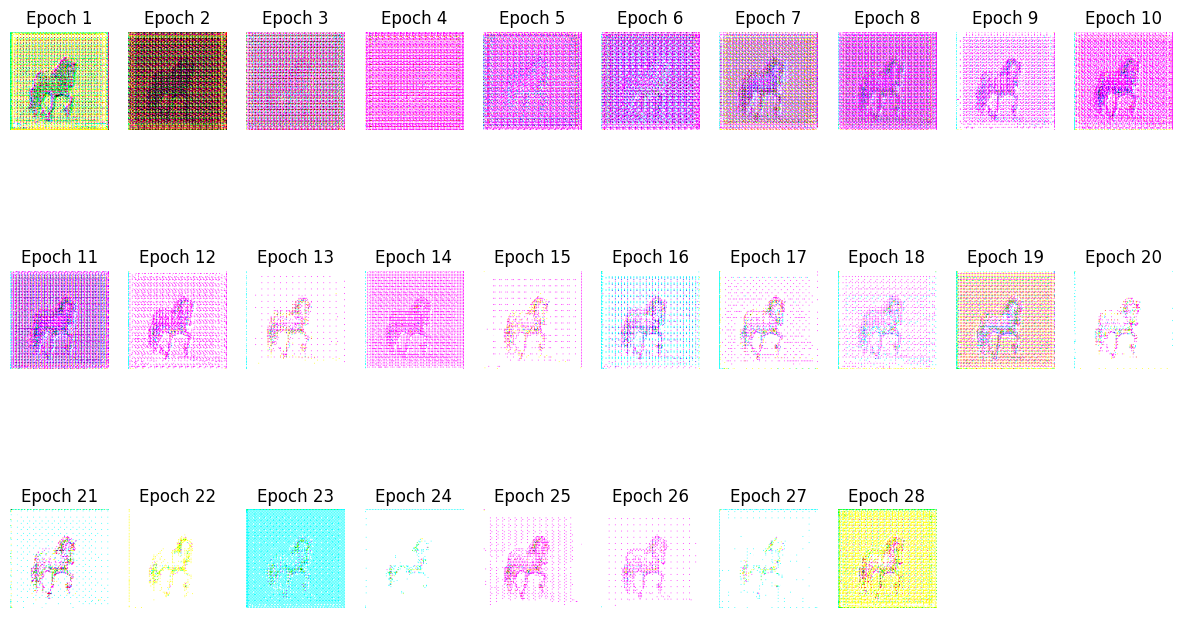

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming `model`, `data_loader`, and `sample_data` are defined

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# If multiple GPUs are available, parallelize the model
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Move the model to the appropriate device
model.to(device)

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50
training_losses = []

# Early stopping parameters
patience = 5
best_loss = float('inf')
epochs_no_improve = 0

# Create a figure for subplots
plt.figure(figsize=(15, 15))

for epoch in range(n_epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = running_loss / len(data_loader)
    training_losses.append(avg_loss)
    
    # After each epoch, generate and plot the output for the saved input sample
    with torch.no_grad():
        model.eval()
        sample_output = model(sample_data.to(device))
        model.train()

    output_np = sample_output.detach().cpu().numpy()  # Move tensor to CPU before converting to numpy
    output_np = np.transpose(output_np, (0, 2, 3, 1))  # Transpose for plotting

    # Plot the output image in a subplot
    plt.subplot(5, 10, epoch + 1)
    plt.imshow(output_np[0])
    plt.axis('off')
    plt.title(f'Epoch {epoch+1}')

    print(f"Epoch {epoch+1} Loss: {avg_loss}")

    # Save checkpoint
    checkpoint_dir = "/kaggle/working/"
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")

    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

In [13]:
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np

# # Assuming `model`, `data_loader`, and `sample_data` are defined
# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# n_epochs = 50
# training_losses = []

# # Early stopping parameters
# patience = 5
# best_loss = float('inf')
# epochs_no_improve = 0

# # Create a figure for subplots
# plt.figure(figsize=(15, 15))

# for epoch in range(n_epochs):
#     running_loss = 0.0
#     for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
    
#     # Calculate average loss for the epoch
#     avg_loss = running_loss / len(data_loader)
#     training_losses.append(avg_loss)
    
#     # After each epoch, generate and plot the output for the saved input sample
#     with torch.no_grad():
#         model.eval()
#         sample_output = model(sample_data)
#         model.train()

#     output_np = sample_output.detach().cpu().numpy()  # Move tensor to CPU before converting to numpy
#     output_np = np.transpose(output_np, (0, 2, 3, 1))  # Transpose for plotting

#     # Plot the output image in a subplot
#     plt.subplot(5, 10, epoch + 1)
#     plt.imshow(output_np[0])
#     plt.axis('off')
#     plt.title(f'Epoch {epoch+1}')

#     print(f"Epoch {epoch+1} Loss: {avg_loss}")

#     # Save checkpoint
#     checkpoint_path = f"/kaggle/input/model_epoch_{epoch+1}.pth"
#     torch.save(model.state_dict(), checkpoint_path)
#     print(f"Checkpoint saved: {checkpoint_path}")

#     # Early stopping check
#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         epochs_no_improve = 0
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve >= patience:
#             print("Early stopping triggered")
#             break



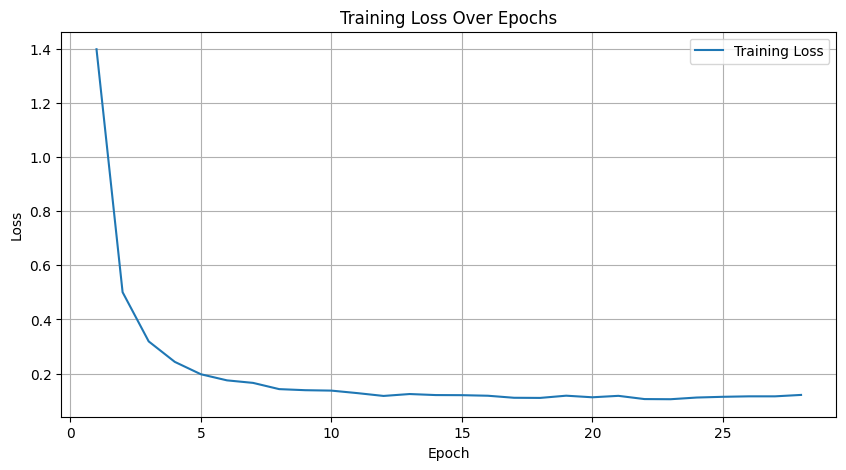

In [14]:
# Plot training loss after all epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


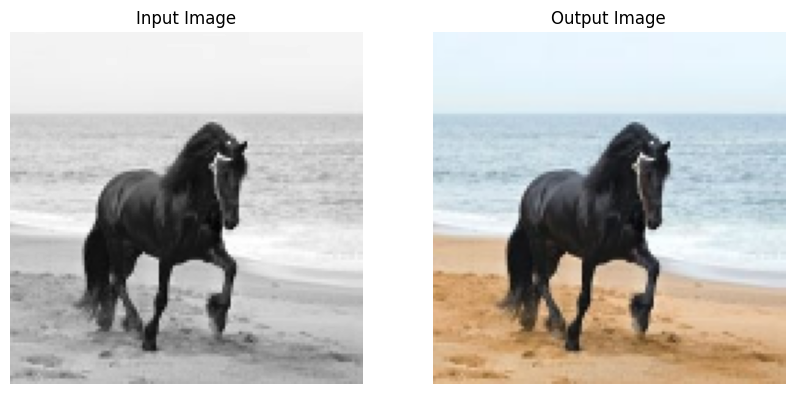

In [15]:
import cv2
import matplotlib.pyplot as plt

# Load the original image
original_img = cv2.imread(os.path.join(data_dir, "horses", "horse-1.jpg"))



resized_img = cv2.resize(original_img, (128, 128))
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the resized grayscale image on the first subplot
axes[0].imshow(gray_img, cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')

# Plot the original image on the second subplot
axes[1].imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
axes[1].set_title('Output Image')
axes[1].axis('off')

plt.show()


# testing in one image

In [16]:
def load_model_and_infer(checkpoint_path, sample_image):
    model = UNet()
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    with torch.no_grad():
        sample_image = sample_image.to(device)
        output = model(sample_image)
        output_np = output.detach().cpu().numpy()
        output_np = np.transpose(output_np, (0, 2, 3, 1))  # Transpose for plotting
        plt.imshow(output_np[0])
        plt.axis('off')
        plt.title('Inference Result')
        plt.show()



In [17]:
import torch
import torch.nn as nn
import cv2
import numpy as np
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.downconv1 = DoubleConv(1, 64)
        self.downconv2 = DoubleConv(64, 128)
        self.downconv3 = DoubleConv(128, 256)
        self.downconv4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2, bias=False)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2, bias=False)
        self.upconv3 = nn.ConvTranspose2d(128, 64, 2, 2, bias=False)
        self.upconv4 = nn.ConvTranspose2d(64, 3, 1, 1, bias=False)

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.pool(x1)
        x3 = self.downconv2(x2)
        x4 = self.pool(x3)
        x5 = self.downconv3(x4)
        x6 = self.pool(x5)
        x7 = self.downconv4(x6)
        x = self.upconv1(x7)
        x = self.upconv2(x + x5)
        x = self.upconv3(x + x3)
        x = self.upconv4(x + x1)
        return x
def preprocess_image(image_path, is_gray=False):
    img = cv2.imread(image_path)
    if not is_gray: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(img, (128,128))
#     plt.imshow(resized, cmap="gray")
    sample_data = np.expand_dims(resized, axis=0)
    # input_data = np.expand_dims(input_data, axis=0)

    sample_data = torch.from_numpy(sample_data).unsqueeze(0).float()
    return sample_data

loaded_model = UNet()
checkpoint_path = "model_epoch_1.pth"  # Adjust the path to your checkpoint
loaded_model.load_state_dict(torch.load(checkpoint_path))
loaded_model.eval()
image_path = os.path.join(data_dir, "horses", "horse-1.jpg")
input_image = preprocess_image(image_path)

# Make predictions
with torch.no_grad():
    output = loaded_model(input_image)

# Convert the output to a format suitable for visualization
output_np = output.squeeze().permute(1, 2, 0).numpy()  # Remove batch dimension and rearrange dimensions

# Plot the original grayscale image and the colorized output
plt.figure(figsize=(10, 5))

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(img, (128,128))
plt.subplot(1, 2, 1)
plt.imshow(resized, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

# Colorized output
plt.subplot(1, 2, 2)
plt.imshow(output_np)
plt.title('Colorized Image')
plt.axis('off')

plt.show()

RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "downconv1.conv.0.weight", "downconv1.conv.1.weight", "downconv1.conv.1.bias", "downconv1.conv.1.running_mean", "downconv1.conv.1.running_var", "downconv1.conv.3.weight", "downconv1.conv.4.weight", "downconv1.conv.4.bias", "downconv1.conv.4.running_mean", "downconv1.conv.4.running_var", "downconv2.conv.0.weight", "downconv2.conv.1.weight", "downconv2.conv.1.bias", "downconv2.conv.1.running_mean", "downconv2.conv.1.running_var", "downconv2.conv.3.weight", "downconv2.conv.4.weight", "downconv2.conv.4.bias", "downconv2.conv.4.running_mean", "downconv2.conv.4.running_var", "downconv3.conv.0.weight", "downconv3.conv.1.weight", "downconv3.conv.1.bias", "downconv3.conv.1.running_mean", "downconv3.conv.1.running_var", "downconv3.conv.3.weight", "downconv3.conv.4.weight", "downconv3.conv.4.bias", "downconv3.conv.4.running_mean", "downconv3.conv.4.running_var", "downconv4.conv.0.weight", "downconv4.conv.1.weight", "downconv4.conv.1.bias", "downconv4.conv.1.running_mean", "downconv4.conv.1.running_var", "downconv4.conv.3.weight", "downconv4.conv.4.weight", "downconv4.conv.4.bias", "downconv4.conv.4.running_mean", "downconv4.conv.4.running_var", "upconv1.weight", "upconv2.weight", "upconv3.weight", "upconv4.weight". 
	Unexpected key(s) in state_dict: "module.downconv1.conv.0.weight", "module.downconv1.conv.1.weight", "module.downconv1.conv.1.bias", "module.downconv1.conv.1.running_mean", "module.downconv1.conv.1.running_var", "module.downconv1.conv.1.num_batches_tracked", "module.downconv1.conv.3.weight", "module.downconv1.conv.4.weight", "module.downconv1.conv.4.bias", "module.downconv1.conv.4.running_mean", "module.downconv1.conv.4.running_var", "module.downconv1.conv.4.num_batches_tracked", "module.downconv2.conv.0.weight", "module.downconv2.conv.1.weight", "module.downconv2.conv.1.bias", "module.downconv2.conv.1.running_mean", "module.downconv2.conv.1.running_var", "module.downconv2.conv.1.num_batches_tracked", "module.downconv2.conv.3.weight", "module.downconv2.conv.4.weight", "module.downconv2.conv.4.bias", "module.downconv2.conv.4.running_mean", "module.downconv2.conv.4.running_var", "module.downconv2.conv.4.num_batches_tracked", "module.downconv3.conv.0.weight", "module.downconv3.conv.1.weight", "module.downconv3.conv.1.bias", "module.downconv3.conv.1.running_mean", "module.downconv3.conv.1.running_var", "module.downconv3.conv.1.num_batches_tracked", "module.downconv3.conv.3.weight", "module.downconv3.conv.4.weight", "module.downconv3.conv.4.bias", "module.downconv3.conv.4.running_mean", "module.downconv3.conv.4.running_var", "module.downconv3.conv.4.num_batches_tracked", "module.downconv4.conv.0.weight", "module.downconv4.conv.1.weight", "module.downconv4.conv.1.bias", "module.downconv4.conv.1.running_mean", "module.downconv4.conv.1.running_var", "module.downconv4.conv.1.num_batches_tracked", "module.downconv4.conv.3.weight", "module.downconv4.conv.4.weight", "module.downconv4.conv.4.bias", "module.downconv4.conv.4.running_mean", "module.downconv4.conv.4.running_var", "module.downconv4.conv.4.num_batches_tracked", "module.upconv1.weight", "module.upconv2.weight", "module.upconv3.weight", "module.upconv4.weight". 

In [ ]:
def preprocess_image(image_path, is_gray=False):
    img = cv2.imread(image_path)
    if not is_gray: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(img, (128,128))
#     plt.imshow(resized, cmap="gray")
    sample_data = np.expand_dims(resized, axis=0)
    # input_data = np.expand_dims(input_data, axis=0)

    sample_data = torch.from_numpy(sample_data).unsqueeze(0).float()
    return sample_data

# Train from the saved checkpoint

In [ ]:
# import os
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
# import cv2

# # Define the dataset
# class MyDataset(Dataset):
#     def __init__(self):
#         self.data_dir = "/kaggle/input/images-dataset/data/"
#         categories = os.listdir(self.data_dir)
#         self.images = []
#         for cat in categories:
#             temp_images = os.listdir(os.path.join(self.data_dir, cat))
#             temp_images = [f"{cat}/{img}" for img in temp_images]
#             self.images.extend(temp_images)
#         print("Number of examples: ", len(self.images))

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         try:
#             image = cv2.imread(os.path.join(self.data_dir, self.images[idx]))
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             image = cv2.resize(image, (128, 128))
#             gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#         except:
#             image = np.random.rand(128, 128, 3) * 255
#             gray_image = np.random.rand(128, 128) * 255
#         return transforms.ToTensor()(gray_image), transforms.ToTensor()(image)

# # Define the UNet model
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.conv(x)

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.downconv1 = DoubleConv(1, 64)
#         self.downconv2 = DoubleConv(64, 128)
#         self.downconv3 = DoubleConv(128, 256)
#         self.downconv4 = DoubleConv(256, 512)
#         self.pool = nn.MaxPool2d(2)
#         self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2, bias=False)
#         self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2, bias=False)
#         self.upconv3 = nn.ConvTranspose2d(128, 64, 2, 2, bias=False)
#         self.upconv4 = nn.ConvTranspose2d(64, 3, 1, 1, bias=False)

#     def forward(self, x):
#         x1 = self.downconv1(x)
#         x2 = self.pool(x1)
#         x3 = self.downconv2(x2)
#         x4 = self.pool(x3)
#         x5 = self.downconv3(x4)
#         x6 = self.pool(x5)
#         x7 = self.downconv4(x6)
#         x = self.upconv1(x7)
#         x = self.upconv2(x + x5)
#         x = self.upconv3(x + x3)
#         x = self.upconv4(x + x1)
#         return x

# # Training function with checkpointing and early stopping
# def train_model(model, data_loader, sample_data, n_epochs=50, lr=0.001, early_stopping_patience=5, checkpoint_path=None):
#     criterion = nn.L1Loss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     training_losses = []
#     best_loss = float('inf')
#     patience_counter = 0

#     # Load checkpoint if provided
#     start_epoch = 0
#     if checkpoint_path and os.path.exists(checkpoint_path):
#         checkpoint = torch.load(checkpoint_path)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         start_epoch = checkpoint['epoch'] + 1
#         training_losses = checkpoint['training_losses']
#         print(f"Loaded checkpoint from epoch {start_epoch}")

#     fig, axs = plt.subplots(n_epochs // 5, 5, figsize=(20, 20))
#     axs = axs.ravel()

#     for epoch in range(start_epoch, n_epochs):
#         running_loss = 0.0
#         for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
        
#         # Calculate average loss for the epoch
#         avg_loss = running_loss / len(data_loader)
#         training_losses.append(avg_loss)
        
#         # Plot the output image
#         with torch.no_grad():
#             model.eval()
#             sample_output = model(sample_data)
#             model.train()

#         output_np = sample_output.detach().cpu().numpy()
#         output_np = np.transpose(output_np, (0, 2, 3, 1))
        
#         axs[epoch].imshow(output_np[0])
#         axs[epoch].axis('off')
#         axs[epoch].set_title(f'Epoch {epoch+1}')
        
#         print(f"Epoch {epoch+1} Loss: {avg_loss}")

#         # Save checkpoint
#         checkpoint = {
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'training_losses': training_losses
#         }
#         checkpoint_save_path = f"/kaggle/input/model_epoch_{epoch+1}.pth"
#         torch.save(checkpoint, checkpoint_save_path)
#         print(f"Checkpoint saved: {checkpoint_save_path}")

#         # Early stopping
#         if avg_loss < best_loss:
#             best_loss = avg_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= early_stopping_patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break

#     plt.show()

#     # Plot training loss after all epochs
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training Loss Over Epochs')
#     plt.legend()
#     plt.grid()
#     plt.show()

# # Sample usage
# dataset = MyDataset()
# data_loader = DataLoader(dataset, batch_size=4, shuffle=True)
# sample_data, _ = next(iter(data_loader))

# model = UNet()
# train_model(model, data_loader, sample_data, n_epochs=50, lr=0.001, early_stopping_patience=5, checkpoint_path=None)
